In [175]:
import json
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
import numpy
import random
import gzip
import math
import pandas as pd

In [176]:

with gzip.open("renttherunway_final_data.json.gz", mode="rt") as f:
    data = f.read()

In [177]:
f = gzip.open("renttherunway_final_data.json.gz")
dataset = []
for l in f:
    dataset.append(json.loads(l))

In [178]:
dataset

[{'fit': 'fit',
  'user_id': '420272',
  'bust size': '34d',
  'item_id': '2260466',
  'weight': '137lbs',
  'rating': '10',
  'rented for': 'vacation',
  'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
  'body type': 'hourglass',
  'review_summary': 'So many compliments!',
  'category': 'romper',
  'height': '5\' 8"',
  'size': 14,
  'age': '28',
  'review_date': 'April 20, 2016'},
 {'fit': 'fit',
  'user_id': '273551',
  'bust size': '34b',
  'item_id': '153475',
  'weight': '132lbs',
  'rating': '10',
  'rented for': 'other',
  'review_text': 'I rented this dress for a photo shoot. The theme was "Hollywood Glam and Big Beautiful Hats". The dress was very comfortable and easy to move around in. It is definitely on my list to rent again for another formal event. ',
  'body type': 'straight & narr

In [179]:
df = pd.read_json("renttherunway_final_data.json.gz", lines=True)

In [180]:
# loading and processing dataset

df = pd.DataFrame(dataset)

# dropping all rows with null values

df = df.dropna()

# converting necessary columns to numeric format

df['weight'] = pd.to_numeric(df['weight'].str.split('lbs').str[0])
df['age'] = pd.to_numeric(df['age'])
df['rating'] = pd.to_numeric(df['rating'])
df['size'] = pd.to_numeric(df['size'])

# for example, 5 ft 8 inches will be represented as 5.08, 5'11" will be 5.11

height_feet = pd.to_numeric(df['height'].str.split("'").str[0])
ser = df['height'].str.split().str[1]
height_inches = pd.to_numeric(ser.str.split('"').str[0])
df['height'] = (height_feet*12) + height_inches

# drop user id, item id, review date

df = df.drop(columns = ['user_id', 'review_date'])

In [181]:
df

,fit,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age
0,fit,34d,2260466,137,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,68,14,28
1,fit,34b,153475,132,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,66,12,36
3,fit,34c,126335,135,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65,8,34
4,fit,34b,616682,145,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,69,12,27
5,fit,32b,364092,138,8,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,68,8,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
192539,fit,34dd,2252812,140,10,work,Fit like a glove!,hourglass,LOVE IT!!! First Item Im thinking of buying!,jumpsuit,69,8,42
192540,fit,32c,682043,100,10,work,The pattern contrast on this dress is really s...,petite,LOVE it!,dress,61,4,29
192541,fit,36a,683251,135,6,everyday,"Like the other DVF wraps, the fit on this is f...",straight & narrow,"Loud patterning, flattering fit",dress,68,8,31
192542,fit,36c,126335,165,10,wedding,This dress was PERFECTION. it looked incredib...,pear,loved this dress it was comfortable and photog...,dress,66,16,31


In [182]:
df['fit_numeric'] = df['fit'].apply(lambda x: 0 if x == 'fit' else 1 if x == 'small' else 2)

In [183]:
df[df['fit'] == 'large']

,fit,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,fit_numeric
11,large,34b,130259,135,8,wedding,This dress was absolutely gorgeous and I recei...,pear,"Stunning dress, perfect for a New Year's Eve w...",dress,66,8,30,2
13,large,36d,143094,142,8,party,I ordered this dress as a replacement because ...,apple,Ordered this as a replacement dress,dress,62,20,29,2
51,large,32c,973512,136,10,party,This dress definitely runs a little large - es...,athletic,Gorgeous flowy dress,dress,67,4,35,2
58,large,34b,808736,125,8,work,"Runs a little large and long, I am 5'7 and 130...",straight & narrow,"Cute dress, thick material",dress,67,8,32,2
64,large,34b,2107747,135,10,date,"Want want want \nIt's such a thick cable, soft...",pear,Brunch top for sure!! \nIt's like wearing your...,sweater,65,14,29,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192499,large,32c,126335,125,10,wedding,This dress was beautiful!! Wore it to a cockta...,athletic,"Gorgeous dress!! 1st experience with RTR, but ...",dress,64,4,39,2
192510,large,32a,1738544,120,8,wedding,Loved the color. Received several compliments....,petite,Wore for summer wedding,dress,63,4,29,2
192525,large,36d,1568818,168,8,party,I wore this to my husband's holiday party that...,apple,"Fun, flirty dress - great for a holiday party!",dress,67,24,38,2
192536,large,34d,166633,127,8,wedding,Based on reviews I ordered a 4 and a 6. The 4 ...,full bust,"I received so many compliments on the dress, ...",mini,65,8,33,2


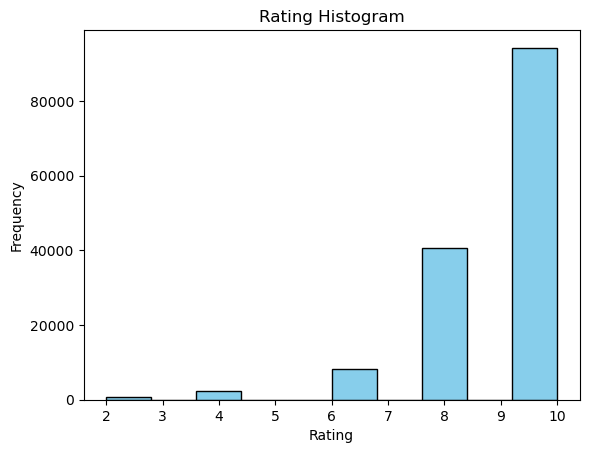

In [184]:
plt.hist(df['rating'], color='skyblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Histogram')
plt.show()

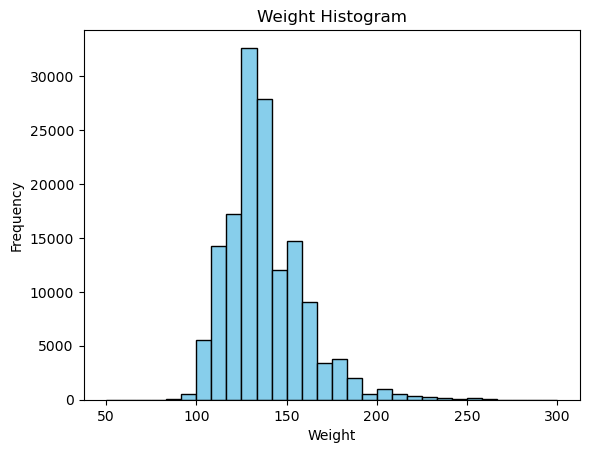

In [185]:
plt.hist(df['weight'], bins = 30, color='skyblue', edgecolor='black')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Weight Histogram')
plt.show()

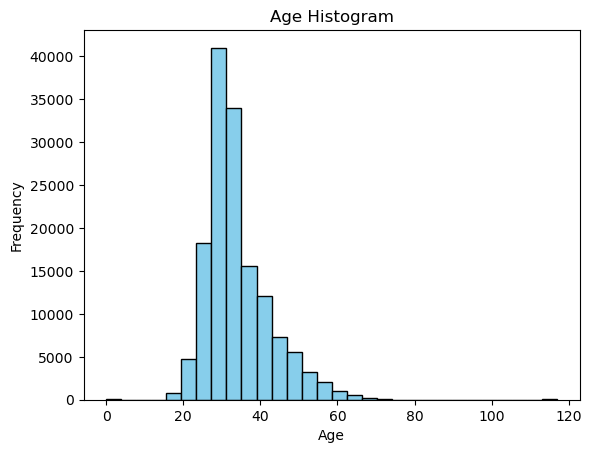

In [186]:
plt.hist(df['age'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Histogram')
plt.show()

In [187]:
age_mean = df['age'].mean()
age_median = df['age'].median()
age_mean, age_median

(34.08979990572547, 32.0)

In [188]:
df['body type'].unique()

array(['hourglass', 'straight & narrow', 'pear', 'athletic', 'full bust',
       'petite', 'apple'], dtype=object)

In [189]:
df['category'].unique()

array(['romper', 'gown', 'dress', 'sheath', 'leggings', 'sweater',
       'jacket', 'shirtdress', 'jumpsuit', 'shift', 'top', 'shirt',
       'mini', 'skirt', 'maxi', 'pants', 'suit', 'coat', 'blouse',
       'trench', 'cape', 'bomber', 'blazer', 'vest', 'duster', 'ballgown',
       'tank', 'poncho', 'frock', 'tunic', 'cardigan', 'down', 'culottes',
       'midi', 'legging', 'print', 'pant', 'knit', 'culotte',
       'sweatshirt', 'peacoat', 'trouser', 'kaftan', 'overalls', 'jogger',
       'tee', 'combo', 'henley', 'blouson', 'pullover', 'turtleneck',
       'trousers', 'overcoat', 'hoodie', 't-shirt', 'caftan', 'tight',
       'kimono', 'cami', 'for', 'crewneck', 'skirts', 'parka',
       'buttondown', 'skort', 'sweatershirt', 'jeans', 'sweatpants'],
      dtype=object)

(array([4.1000e+01, 0.0000e+00, 1.5500e+02, 5.4000e+03, 3.7469e+04,
        5.5771e+04, 2.2557e+04, 1.2347e+04, 7.0840e+03, 3.7580e+03,
        1.2970e+03, 3.8700e+02, 4.2000e+01, 4.0000e+00, 4.0000e+00,
        1.8000e+01, 3.0000e+00, 1.0000e+00, 1.0000e+00, 4.2000e+01]),
 array([  0.  ,   5.85,  11.7 ,  17.55,  23.4 ,  29.25,  35.1 ,  40.95,
         46.8 ,  52.65,  58.5 ,  64.35,  70.2 ,  76.05,  81.9 ,  87.75,
         93.6 ,  99.45, 105.3 , 111.15, 117.  ]),
 <BarContainer object of 20 artists>)

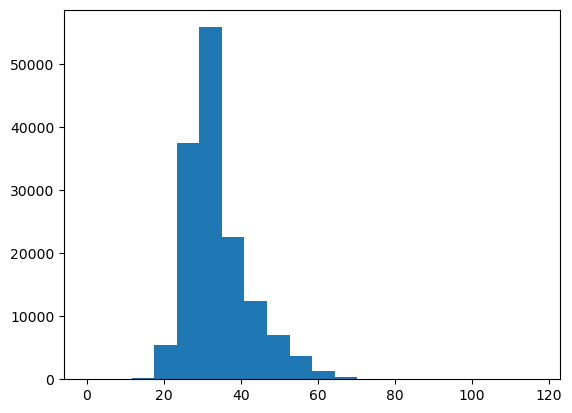

In [190]:
plt.hist(df['age'], bins = 20)

(array([3.6000e+01, 2.2100e+02, 9.5840e+03, 2.9254e+04, 4.0039e+04,
        4.9888e+04, 1.3684e+04, 3.5400e+03, 1.2000e+02, 1.5000e+01]),
 array([54. , 56.4, 58.8, 61.2, 63.6, 66. , 68.4, 70.8, 73.2, 75.6, 78. ]),
 <BarContainer object of 10 artists>)

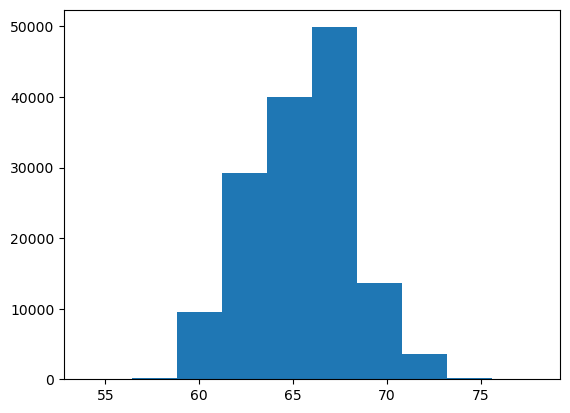

In [191]:
plt.hist(df['height'])

In [192]:
# percentage of data reported as fit

print("Percentage of items reported as fit: " + str(df[df['fit'] == 'fit'].shape[0] / df.shape[0]))
print("Percentage of items reported as small: " + str(df[df['fit'] == 'small'].shape[0] / df.shape[0]))
print("Percentage of items reported as large: " + str(df[df['fit'] == 'large'].shape[0] / df.shape[0]))

Percentage of items reported as fit: 0.7359766636380405
Percentage of items reported as small: 0.1340474515135161
Percentage of items reported as large: 0.12997588484844344


In [193]:
df['fit'].unique()

array(['fit', 'small', 'large'], dtype=object)

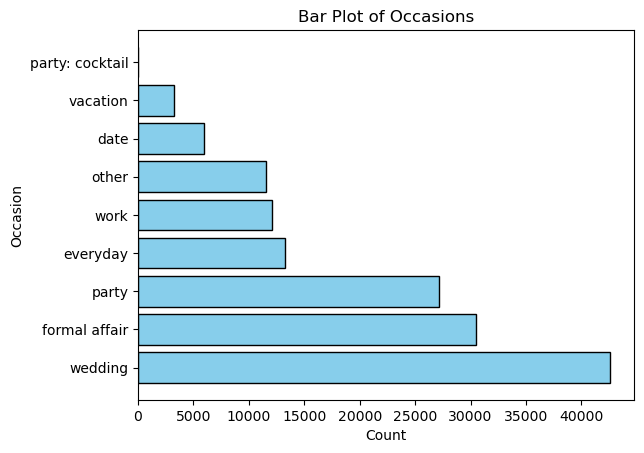

In [194]:
category_counts = df['rented for'].value_counts()

# Plot horizontal bar plot
plt.barh(category_counts.index, category_counts.values, color = 'skyblue', edgecolor = 'black')

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Occasion')
plt.title('Bar Plot of Occasions')

# Show the plot
plt.show()

In [195]:
category_counts[:20]

rented for
wedding            42622
formal affair      30496
party              27198
everyday           13263
work               12124
other              11510
date                5929
vacation            3238
party: cocktail        1
Name: count, dtype: int64

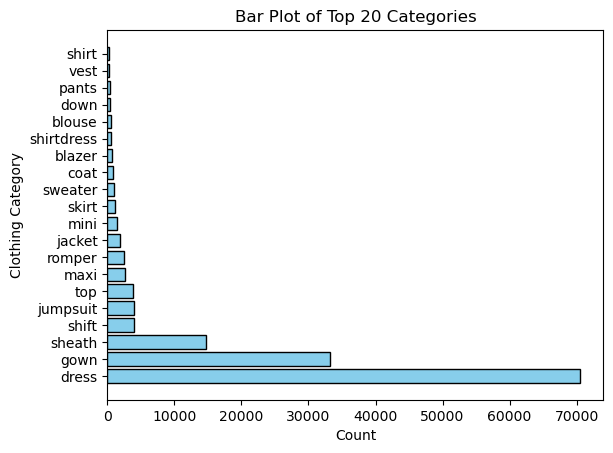

In [196]:
category_counts = df['category'].value_counts()[:20]

#plt.figure(figsize=(13, 13))

plt.barh(category_counts.index, category_counts.values, color = 'skyblue', edgecolor = 'black')

plt.xlabel('Count')
plt.ylabel('Clothing Category')
plt.title('Bar Plot of Top 20 Categories')

plt.show()

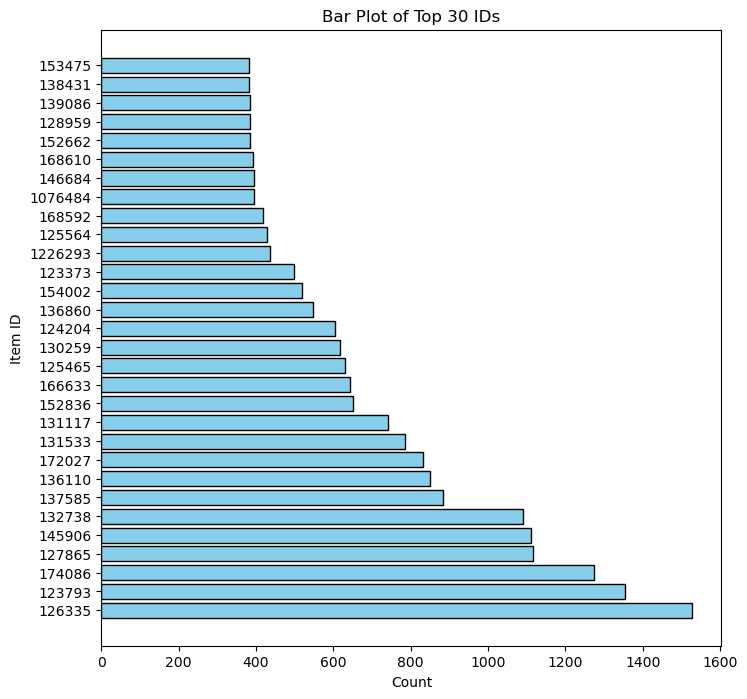

In [197]:
category_counts = df['item_id'].value_counts()[:30]

plt.figure(figsize=(8, 8))

plt.barh(category_counts.index, category_counts.values, color = 'skyblue', edgecolor = 'black')

plt.xlabel('Count')
plt.ylabel('Item ID')
plt.title('Bar Plot of Top 30 IDs')

plt.show()

In [198]:
df[df['item_id'] == '126335']

,fit,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,fit_numeric
3,fit,34c,126335,135,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,65,8,34,0
72,large,34d,126335,128,10,formal affair,"I normally wear a 4, but ended up wearing the ...",full bust,"The dress was fun, comfortable and pretty.",dress,68,4,48,2
208,large,34b,126335,140,10,wedding,My back-up size for the original dress that I ...,pear,Wish I had somewhere else to go....,dress,62,12,38,2
291,large,34b,126335,145,6,wedding,Dress was more pinkish than the picture. I wo...,athletic,RTR is very easy to rent and send back.There i...,dress,64,12,40,2
464,small,36c,126335,190,6,formal affair,"Overall, I loved this dress and I thought it f...",hourglass,A glitzy showstopper that made me stand out at...,dress,70,28,26,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191950,large,34b,126335,130,6,formal affair,"Runs big, just like the rest of the comments s...",hourglass,Got a ton of compliments on this gorgeous & cl...,dress,64,4,25,2
192014,fit,34b,126335,155,8,party,I wore this to my office holiday party and eve...,pear,So sparkly! Perfect for a holiday or NYE party.,dress,71,12,33,0
192338,fit,38d+,126335,217,10,formal affair,I absolutely loved this dress! I received comp...,apple,I was aiming for a vintage movie star look for...,dress,64,51,31,0
192499,large,32c,126335,125,10,wedding,This dress was beautiful!! Wore it to a cockta...,athletic,"Gorgeous dress!! 1st experience with RTR, but ...",dress,64,4,39,2


In [199]:
df[df['item_id'] == '174086']

,fit,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,fit_numeric
37,fit,34c,174086,130,8,wedding,I rented this dress in both a 0 and a 2 and en...,straight & narrow,"Was a littttttle big for me, but still super c...",dress,66,1,29,0
98,fit,32c,174086,130,10,wedding,The dress fit perfectly and looked absoultely ...,pear,PERFECT!!,dress,65,4,36,0
990,fit,32b,174086,110,10,wedding,"Fit true to size,",petite,"Loves this dress. Comfortable, great fit, Stun...",dress,61,1,41,0
1178,fit,32b,174086,130,8,wedding,"The dress was just a touch short, and slightly...",athletic,My first RTR experience!,dress,64,1,31,0
1314,fit,32d,174086,110,10,formal affair,I loved this dress and felt beautiful in it! t...,petite,love this dress!!,dress,60,4,22,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191796,fit,32b,174086,140,10,wedding,I've rented a bunch of Shoshanna dresses and t...,pear,Obsessed with Shoshanna Dresses!,dress,63,4,32,0
191813,large,32b,174086,115,6,wedding,I rented this dress and another dress for my s...,petite,beautiful dress with great color!,dress,64,8,27,2
192205,fit,32d,174086,128,10,wedding,This dress fit great! It was the perfect lengt...,hourglass,Compliments all night!,dress,63,4,28,0
192236,fit,36d+,174086,150,8,date,This dress was comfortable and perfect for a n...,full bust,Unique red-orange color and beautiful lace!,dress,63,20,32,0


In [200]:
df[df['item_id'] == '123793']

,fit,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,fit_numeric
14,fit,34b,123793,118,10,formal affair,"Fit great, super flattering",athletic,Stunning gown. Wore this for heart ball and re...,gown,65,2,32,0
443,large,34b,123793,138,8,formal affair,Limited range of arm motion but excellent comf...,athletic,This was a stand out dress! I was complimented...,gown,66,4,28,2
478,large,34b,123793,138,10,wedding,"GORGEOUS dress! Super classy, with a touch of ...",pear,Glam glam glam,gown,66,9,29,2
622,fit,36c,123793,145,10,wedding,It hugs around the hips and body really nicely...,pear,I got soooo many compliments!!,gown,56,13,25,0
684,small,34a,123793,165,10,formal affair,"Gorgeous, billions of compliments. This was o...",athletic,Loved it! Wore it to prom,gown,70,25,21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192033,fit,34c,123793,150,8,wedding,I am 5'7'' and wore the 8L. The long still wa...,athletic,Wore it as a bridesmaid dresses in my sisters ...,gown,67,13,29,0
192077,fit,36d,123793,150,10,wedding,"It fits perfect, I'm a 36D and was able to wea...",hourglass,I got so many compliments and I was unique.,gown,63,20,56,0
192107,large,36d,123793,175,10,formal affair,The dress was amazing. Stretchier than what I ...,hourglass,The dress was the perfect dress to make me fee...,gown,68,21,35,2
192266,fit,32b,123793,105,10,formal affair,It is so comfortable and easy to dance in. I'm...,hourglass,I wore this for my senior prom and loved it! I...,gown,67,2,23,0


In [201]:
df['bust size'].unique()

array(['34d', '34b', '34c', '32b', '34d+', '36a', '36d', '32d+', '32c',
       '30dd', '36b', '36c', '32d', '34a', '34dd', '32a', '34ddd/e',
       '38d+', '38a', '38b', '38d', '36ddd/e', '38dd', '38f', '42dd',
       '40dd', '32dd', '38c', '30ddd/e', '32ddd/e', '36dd', '36d+', '40d',
       '28dd', '42c', '30d', '30b', '34aa', '32aa', '36f', '28c', '36aa',
       '34g', '42ddd/e', '40c', '34f', '28g', '28aa', '36g', '28f',
       '44ddd/e', '42d', '40ddd/e', '30c', '30aa', '44dd', '32i', '32g',
       '30g', '30h', '30a', '34j', '38ddd/e', '32h', '28a', '32f', '44d',
       '40h', '38g', '40g', '28b', '34h', '36j', '36h', '28ddd/e', '44f',
       '34i', '30f', '36i', '30i', '28h', '42b', '42j', '40f', '38aa',
       '38i', '48dd', '28d', '46ddd/e', '42g', '48d', '38h', '40b', '40j',
       '32j', '38j', '44b', '44c', '44g', '42f', '44h'], dtype=object)

In [202]:
json_str = df.to_json(orient='records')
with gzip.open('cleaned_dataset.json.gz', 'wt', encoding='utf-8') as f:
    f.write(json_str)

In [203]:
with gzip.open("cleaned_dataset.json.gz", mode="rt") as f:
    data = f.read()

In [204]:
f = gzip.open("cleaned_dataset.json.gz")
dataset = []
for l in f:
    dataset.append(json.loads(l))
dataset = dataset[0]

In [205]:
dataset

[{'fit': 'fit',
  'bust size': '34d',
  'item_id': '2260466',
  'weight': 137,
  'rating': 10,
  'rented for': 'vacation',
  'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
  'body type': 'hourglass',
  'review_summary': 'So many compliments!',
  'category': 'romper',
  'height': 68,
  'size': 14,
  'age': 28,
  'fit_numeric': 0},
 {'fit': 'fit',
  'bust size': '34b',
  'item_id': '153475',
  'weight': 132,
  'rating': 10,
  'rented for': 'other',
  'review_text': 'I rented this dress for a photo shoot. The theme was "Hollywood Glam and Big Beautiful Hats". The dress was very comfortable and easy to move around in. It is definitely on my list to rent again for another formal event. ',
  'body type': 'straight & narrow',
  'review_summary': 'I felt so glamourous!!!',
  'category': 'gown',
  'height

In [206]:
dataTest = dataset[117105:]
dataTrain = dataset[:117105]

print(len(dataTrain))
print(len(dataTest))

117105
29276


In [207]:
def accuracy(predictions, y):
    TP_ = numpy.logical_and(predictions, y)
    FP_ = numpy.logical_and(predictions, numpy.logical_not(y))
    TN_ = numpy.logical_and(numpy.logical_not(predictions), numpy.logical_not(y))
    FN_ = numpy.logical_and(numpy.logical_not(predictions), y)
    TP = sum(TP_)
    FP = sum(FP_)
    TN = sum(TN_)
    FN = sum(FN_)
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    return accuracy

In [209]:
def feat1(datum):
    onehotBodyType = [0]*100

    height = datum['height']
    weight = datum['weight']
    #bodyType = datum['body type']
    size = datum['size']
    #itemID = datum['item_id']
    return [1] + [height] + [weight] + [size]

X = [feat1(d) for d in dataTrain]
y = [d['fit_numeric'] for d in dataTrain]

model = linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = model.predict(X)
sse = sum([x**2 for x in (y - y_pred)])
mse = sse / len(y)

def MSE(predictions, labels):
     differences = [(x-y)**2 for x,y in zip(predictions,labels)]
     return sum(differences) / len(differences)

validMSE = MSE(y_pred, y)
accuracyTest = accuracy(y_pred, y)
print(accuracyTest)
print(validMSE)


0.2643012680927373
0.4992302123035017
